# MCMC

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

import numpy as np
import jax.numpy as jn
from  matplotlib import pyplot as plt
import jax
from jax import random

from src.utils import l2sq
from src.algorithm import*

plt.rcParams["figure.figsize"]=8,8

[[ 7.77250578 -0.04217171]
 [-0.04217171  7.81069033]]


(-12.0, 12.0)

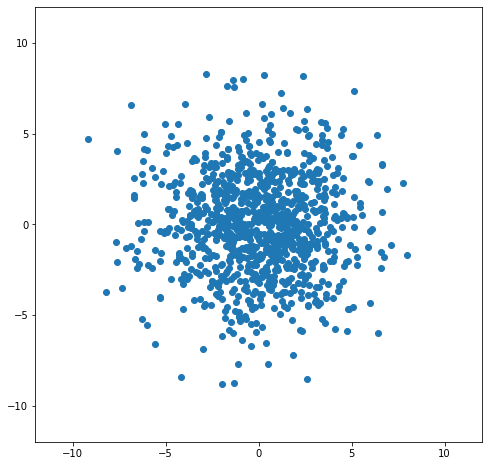

In [2]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

k = 2
M = jnp.zeros(k)
#c = jnp.array([[1,0],[0,10]])
#c_inv = jnp.array([[1, 0], [0,1/10]])

key, *sk = random.split(key, 4)
V = random.normal(sk[0], [k, k])
Q, _ = jnp.linalg.qr(V)
d = jnp.diag(random.uniform(sk[1], (k,))*10)
D= d.at[d < 0].set(0)
C = Q.transpose() @ D @ Q
C_inv = Q.transpose() @ jnp.diag(1/jnp.diag(D)) @ Q
print(C)

S = random.multivariate_normal(sk[2], M, C, (1000,))
plt.scatter(S[:,0], S[:,1])
plt.xlim(-12,12)
plt.ylim(-12,12)

In [3]:
def plot_mcmc_samples(samples, r, x0, M, C):

    plt.rcParams["figure.figsize"]=16,8

    plt.subplot(1,2,1)
    plt.plot(x0[0], x0[1], 'ro')
    plt.scatter(samples[:,0], samples[:,1])
    plt.xlim(-20,20)
    plt.ylim(-20,20)

    plt.subplot(1,2,2)
    plt.plot(r)

    plt.rcParams["figure.figsize"]=8,8

    M_est = jnp.mean(samples, axis = 0)
    print("Mean error =", jnp.linalg.norm(M - M_est))

    C_est = jnp.cov(samples.transpose())
    print("Covariance error =", jnp.linalg.norm(C - C_est)/jnp.linalg.norm(C))

In [4]:
logPi = lambda x : -1/2 * (x-M) @ C_inv @ (x-M) - jnp.log(jnp.sqrt((2*jnp.pi)**k * jnp.linalg.det(C)))
gradLogPi = jax.grad(logPi)

pi = lambda x : jnp.exp(logPi(x))
logPi = jax.jit(logPi)
gradLogPi = jax.jit(gradLogPi)

In [5]:
logPi(jnp.array([10,20]))
gradLogPi(jnp.array([0.,-5.]))

DeviceArray([0.00347339, 0.64016704], dtype=float64)

In [6]:
#x = jnp.arange(-20,20)
#y = [pi(jnp.array([0,xi])) for xi in x]
#plt.plot(x,y)
#plt.show
#y2 = [pi(jnp.array([xi,0])) for xi in x]
#plt.plot(x,y2)
#plt.show()
#y3 = [logPi(jnp.array([0,xi])) for xi in x]
#plt.plot(x,y3)

#gradLogPi(jnp.array([0.,-5.]))

In [7]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))
print(key)

[  0 408]


In [8]:
print(key)
key, sk1, sk2 = random.split(key,3)
print(key)
#print(random.normal(key))

print(sk1)
print(sk2)
#print(random.normal(subkey))


[  0 408]
[3587770966 3905256864]
[2374792740  443129571]
[3947616270 2690156967]


### MALA

In [9]:
x0 = jnp.array(np.random.randn(k))
tau = 1
N = 10000

key, *keys = random.split(key, 2*N+1)

In [10]:
samples_mala = []
samples_mala.append(x0)
r_mala = []
r_mala.append(1)
x1c = x0

t0 = time.time()
for i in jnp.arange(1, N):

    x1p = x1c
    x1c, r = mala_proposal(keys[2*i], logPi, gradLogPi, samples_mala[i-1], tau)
    a = jnp.minimum(1, r)
    r_mala.append(a)
    
    x1c = jax.lax.cond(random.uniform(keys[2*i+1]) < a,
        true_fun = lambda _ : x1c,
        false_fun = lambda _ : x1p,
        operand = None)
    
    samples_mala.append(x1c)
        
print("Time ", time.time()-t0)

samples_mala = jnp.array(samples_mala)
r_mala = jnp.array(r_mala)

Time  61.534656047821045


Mean error = 0.37317449566672406
Covariance error = 0.03273608664532765


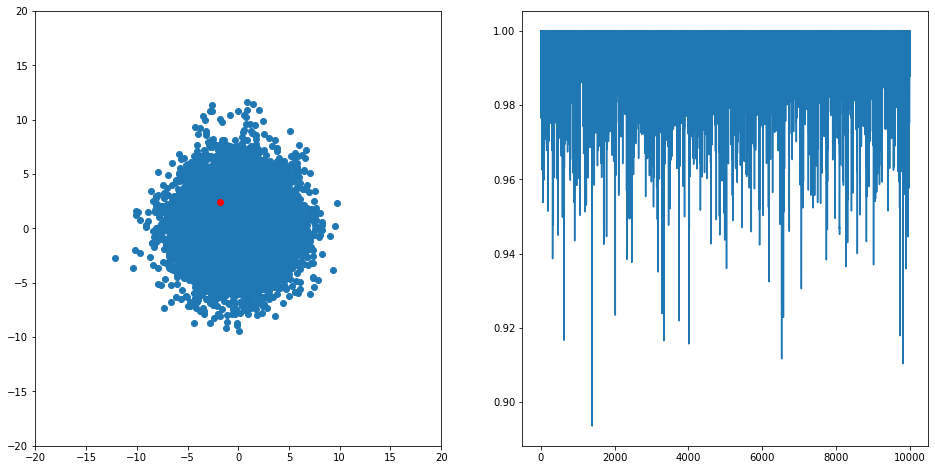

In [11]:
plot_mcmc_samples(samples_mala, r_mala, x0, M, C)

### HMC

In [12]:
dt = 0.1
L = 30
N = 10000

key, *keys = random.split(key, 2*N+1)

In [13]:
samples_hmc = []
samples_hmc.append(x0)
r_hmc = []
r_hmc.append(1)
x1c = x0

t0 = time.time()
for i in range(1, N):
    
    x1c, r = hmc_proposal(keys[i], logPi, gradLogPi, samples_hmc[i-1], dt, L)
    a = jnp.minimum(1, r)
    r_hmc.append(a)
    
    x1c = jax.lax.cond(random.uniform(keys[2*i+1]) < a,
        true_fun = lambda _ : x1c,
        false_fun = lambda _ : x1p,
        operand = None)
    
    samples_hmc.append(x1c)
    
print("Time ", time.time()-t0)
    
samples_hmc = jnp.array(samples_hmc)
r_hmc = jnp.array(r_hmc)

Time  157.71860074996948


Mean error = 0.06393698555468723
Covariance error = 0.0412411457534024


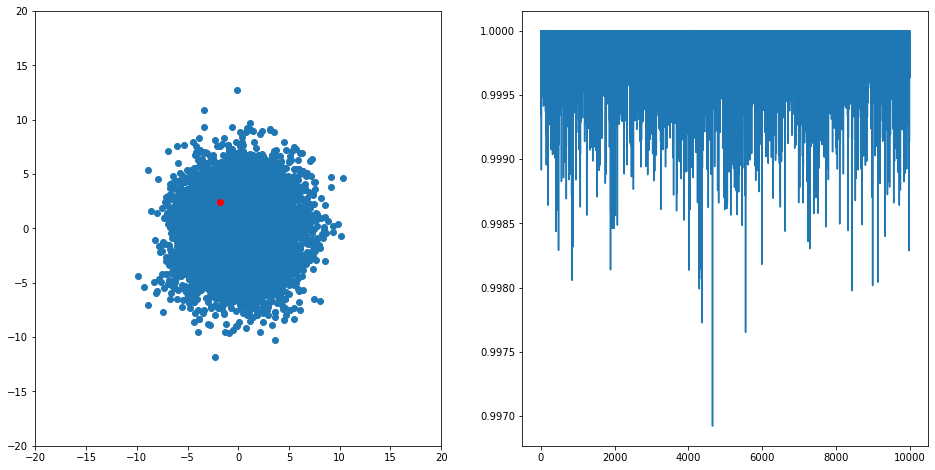

In [14]:
plot_mcmc_samples(samples_hmc, r_hmc, x0, M, C)

In [15]:
def get_norm_conv(samples, M, C):
    norm_m = []
    norm_c = []
    for i in range(10,N):
        if jnp.mod(i,50) == 0:
            Merr = jnp.linalg.norm(jnp.mean(samples[:i], axis = 0) - M)
            Cerr = jnp.linalg.norm(jnp.cov(samples[:i].transpose()) - C)/jnp.linalg.norm(C)
            norm_m.append(Merr)
            norm_c.append(Cerr)

    norm_m = jnp.array(norm_m)
    norm_c = jnp.array(norm_c)
    return norm_m, norm_c

In [16]:
norm_m_hmc, norm_c_hmc = get_norm_conv(samples_hmc, M, C)

In [17]:
norm_m_mala, norm_c_mala = get_norm_conv(samples_mala, M, C)

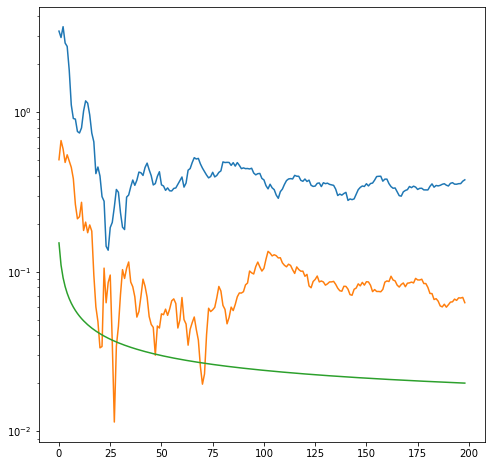

In [35]:
plt.semilogy(norm_m_mala)
plt.semilogy(norm_m_hmc)
plt.semilogy(yy+0.01)

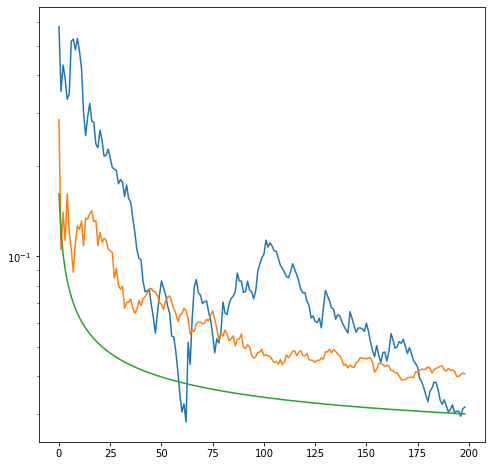

In [36]:
plt.semilogy(norm_c_mala)
plt.semilogy(norm_c_hmc)
plt.semilogy(yy+0.02)

In [20]:
xx = []
for i in range(10,N):
    if jnp.mod(i, 50) == 0:
        xx.append(i)
xx = jnp.array(xx)
yy = 1/jnp.sqrt(xx)

In [21]:
xx.shape

(199,)

In [22]:
norm_c_mala.shape

(199,)